<a href="https://colab.research.google.com/github/hnunezd/Cardiologia/blob/main/cardio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.cluster import DBSCAN, KMeans

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# CARGAR LOS DATOS

Los datos ya se encuentran previamente tabulados en un archivo Excel.

In [ ]:
url="http://raw.githubusercontent.com/castudil/cardiology/master/cardiology.xlsx"
df = pd.read_excel(url)
df.head()

,Urg,Hosp,Or,Pre,recu,Per,Dys,Fai,Ang,Lvef,Rev,High,Con,Ede,Hea,pf
0,0,0,0,0,0,0,0,1,2,0,1,1,0,1,0,0.44971
1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,1,0.64100
2,0,0,0,1,0,1,1,1,1,1,1,1,0,0,1,0.87922
3,0,0,0,0,0,1,1,1,2,0,0,1,1,0,1,0.60164
4,0,0,0,1,0,1,1,0,2,0,0,1,0,1,1,0.67164


#Preparación de los datos

Los datos  corresponden a una naturaleza binaria, a excepción de tres columnas que se modificarán en los siguientes bloques de códigos. Además incluye una categoría especial que se llama pf y corresponde a un Score. Éste puntaje ha sido calculado a través de una función especialmente diseñada para establecer la gravedad de un paciente. pf será extraída del conjunto de datos originales y usadas finalmente para con testar los resultados arrojados por los métodos de aprendizaje no supervisados.

Todas las columnas son de naturaleza numérica

In [ ]:
#se establecen 3 niveles de severidad dependiendo del score de prioridad. Puntajes mayores o iguales a 1.4 se 
#consideran muy severos, score entre 1.4 y 0.7 medianamente severos y menor a 0.7 poco severos. En la columna "sev" 2 representa un paciente muy severo, 
# 1 mediano y 0 poco severo.

filtros = [(df.pf>=1) , 
   (df.pf >= 0.7) & (df.pf < 1), 
   (df.pf < 0.7)]
valores = [2, 1, 0]

df["sev"] = np.select(filtros, valores)

In [ ]:
Counter(df.sev)

Counter({0: 4995, 1: 695, 2: 104})

In [ ]:
score=df["pf"] ## apartar la variable de scoring de gravedad del paciente
sev=df["sev"] # apartar la variable de severidad  del paciente
score.head()
score.shape

(5794,)

In [ ]:
# One hot encoding a variables "Recu",'Dys'y "Ang"
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[["recu",'Dys',"Ang"]]).toarray())

#nuevas columnas se unen a data inicial en df_1
df_1 = df.join(enc_df)
df_1

,Urg,Hosp,Or,Pre,recu,Per,Dys,Fai,Ang,Lvef,...,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,1,2,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,1,0,0,0,0,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0,0,1,0,1,1,1,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,0,0,0,1,1,1,2,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,0,0,1,0,1,1,0,2,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5789,0,0,0,1,0,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5790,0,0,0,0,0,1,1,1,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5791,0,0,0,0,0,1,1,1,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5792,0,0,0,1,0,1,1,0,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
df_1=df_1.drop(["recu","Dys","Ang"],axis=1)

In [ ]:
#renombrar columnas creadas
df_1.rename(columns={0:'recu_0',1:'recu_1',2:'recu_2',3:'recu_3',4:'Dys_0',5:'Dys_1',6:'Dys_2',
                    7:'Ang_0',8:'Ang_1',9:'Ang_2'},
               inplace=True)


In [ ]:
df_2= df_1.copy()

In [ ]:
columns=df_2.columns

In [ ]:
#se eliminan variables "pf" y "sev"
df_2=df_2.drop(["pf","sev"],axis=1)

In [ ]:
#variables flotantes
df_2= df_2.astype(int, errors = 'raise')

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5794 entries, 0 to 5793
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Urg     5794 non-null   int64
 1   Hosp    5794 non-null   int64
 2   Or      5794 non-null   int64
 3   Pre     5794 non-null   int64
 4   Per     5794 non-null   int64
 5   Fai     5794 non-null   int64
 6   Lvef    5794 non-null   int64
 7   Rev     5794 non-null   int64
 8   High    5794 non-null   int64
 9   Con     5794 non-null   int64
 10  Ede     5794 non-null   int64
 11  Hea     5794 non-null   int64
 12  recu_0  5794 non-null   int64
 13  recu_1  5794 non-null   int64
 14  recu_2  5794 non-null   int64
 15  recu_3  5794 non-null   int64
 16  Dys_0   5794 non-null   int64
 17  Dys_1   5794 non-null   int64
 18  Dys_2   5794 non-null   int64
 19  Ang_0   5794 non-null   int64
 20  Ang_1   5794 non-null   int64
 21  Ang_2   5794 non-null   int64
dtypes: int64(22)
memory usage: 996.0 KB


#NORMALIZACION

El siguiente paso consiste en normalizar algunas columnas que tienen opciones más allá de cero a uno. existen tres columnas con estas condiciones Ang,recu y Dys. Estas columnas fueron identificadas a través de una inspección manual del conjunto de datos.

Por una parte la transformación eliminará el concepto de la magnitud absoluta de dichas categorías, lo que afecta la interpretabilidad. Sin embargo, el no realizar la normalización significará que esas columnas tendrán un impacto mayor en los cálculos de distancias internos de los mecanismos de aprendizaje automático, lo que puede llevar a conclusiones erróneas. En otras palabras se trata de un paso necesario para poder procesar los datos con los algoritmosEn otras palabras se trata de un paso necesario para poder procesar los datos con los algoritmos.

In [ ]:
def norm(base):
  x = StandardScaler().fit_transform(base)
  x = pd.DataFrame(x, columns=base.columns)
  return x


In [ ]:
x=norm(df_2)
#x_clinicas=norm(df_2.iloc[:,4:])

#Principal Component Analysis

PCA es una técnica para reducir el número de dimensiones en un conjunto de datos conservando la mayor parte de la información contenida originalmente. Utiliza la correlación entre algunas dimensiones y trata de proporcionar un número mínimo de variables que mantenga la cantidad máxima de variación o información sobre cómo se distribuyen los datos originales. Hace uso de valores propios y vectores propios. Estos vectores se extraen desde la matriz de covarianza y tienen la propiedad de que apuntan a lo largo de las direcciones principales de variación de los datos.

In [ ]:
def pca(data):
  pca = PCA()
  Xt = pca.fit_transform(data)
  var=pca.explained_variance_ratio_*100
  return Xt,var

In [ ]:
Xt,var =pca(x)

In [ ]:
#Varianza Acumulada
np.cumsum(var)[12]

84.09659710025812

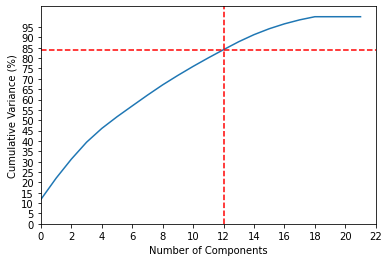

In [ ]:
plt.plot(np.cumsum(var))
plt.ylim(0,105)
plt.xlim(0,22)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance (%)")
plt.axhline(y = 84.09, color = 'r', linestyle = 'dashed')
plt.axvline(x = 12, color = 'r', linestyle = 'dashed')
plt.yticks(range(0, 100, 5))
plt.xticks(range(0, 24, 2))
#plt.savefig("/content/drive/MyDrive/Graficos/cardio/number_components.pdf")
plt.show()

# **DBSCAN**
DBSCAN agrupa puntos que están cerca entre sí en función de una medida de distancia (generalmente distancia euclidiana) y un número mínimo de puntos. También marca como valores atípicos los puntos que se encuentran en regiones de baja densidad.
El algoritmo DBSCAN básicamente requiere 2 parámetros:

eps : especifica qué tan cerca deben estar los puntos entre sí para ser considerados parte de un clúster. Significa que si la distancia entre dos puntos es menor o igual a este valor (eps), estos puntos se consideran vecinos.

minPoints : el número mínimo de puntos para formar una región densa. Por ejemplo, si establecemos el parámetro minPoints en 5, entonces necesitamos al menos 5 puntos para formar una región densa.

Estimación de parámetros.
Para determinar el valor eps óptimo se utiliza la metodología propuesta en "[A Density-Based Algorithm for Discovering Clusters](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)" que consiste en encontrar el codo del gráfico de las k-distancias ordenadas. Con  (2·dim−1) nearest neighbor y minPts=2·dim" [Why and How You Should (Still) Use DBSCAN](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf).


In [ ]:
def eps(x):
  neighbors = NearestNeighbors(n_neighbors=2*x.shape[1])
  neighbors_fit = neighbors.fit(x)
  distances, indices = neighbors_fit.kneighbors(x)
  distances = np.sort(distances, axis=0)
  distances = distances[:,2*x.shape[1]-1]
  kl = KneeLocator(range(0, len(distances)),distances, curve="convex", direction="increasing")
  eps_opti=distances[kl.elbow]
  return eps_opti

In [ ]:
def dbscan(x,eps_opti):  
  modelo=DBSCAN(eps=eps_opti,min_samples=2*x.shape[1])
  pred=modelo.fit(x)
  return pred

In [ ]:
eps_opti=eps(Xt[:,:12])
pred =dbscan(Xt[:,:12],eps_opti)

In [ ]:
print(eps_opti)
print(2*Xt[:,:12].shape[1])

5.138393701576609
24


In [ ]:
Counter(pred.labels_)

Counter({-1: 8, 0: 5572, 1: 39, 2: 125, 3: 50})

DBSCAN identifica 2 cluster y 2 anomalías. 

In [ ]:
df["Db_cluster"]=pred.labels_

In [ ]:
print("Score de prioridad promedio Cluster 0=",df[df["Db_cluster"]==0]["pf"].median())
print("Score de prioridad promedio Cluster 1=",df[df["Db_cluster"]==1]["pf"].median())
print("Score de prioridad promedio Cluster -1=",df[df["Db_cluster"]==-1]["pf"].median())
print("Score de prioridad promedio Cluster 2=",df[df["Db_cluster"]==2]["pf"].median())
print("Score de prioridad promedio Cluster 3=",df[df["Db_cluster"]==3]["pf"].median())

Score de prioridad promedio Cluster 0= 0.45793
Score de prioridad promedio Cluster 1= 0.97129
Score de prioridad promedio Cluster -1= 1.106175
Score de prioridad promedio Cluster 2= 0.61129
Score de prioridad promedio Cluster 3= 0.950145


In [ ]:
print("Score de prioridad promedio Cluster 0=",df[df["Db_cluster"]==0]["pf"].mean())
print("Score de prioridad promedio Cluster 1=",df[df["Db_cluster"]==1]["pf"].mean())
print("Score de prioridad promedio Cluster -1=",df[df["Db_cluster"]==-1]["pf"].mean())
print("Score de prioridad promedio Cluster 2=",df[df["Db_cluster"]==2]["pf"].mean())
print("Score de prioridad promedio Cluster 3=",df[df["Db_cluster"]==3]["pf"].mean())


Score de prioridad promedio Cluster 0= 0.46431979720028715
Score de prioridad promedio Cluster 1= 1.0040407692307691
Score de prioridad promedio Cluster -1= 1.1385899999999998
Score de prioridad promedio Cluster 2= 0.6402040000000001
Score de prioridad promedio Cluster 3= 0.9402676000000001


In [ ]:
print("Score de prioridad promedio Cluster 0=",df[df["Db_cluster"]==0]["pf"].std())
print("Score de prioridad promedio Cluster 1=",df[df["Db_cluster"]==1]["pf"].std())
print("Score de prioridad promedio Cluster -1=",df[df["Db_cluster"]==-1]["pf"].std())
print("Score de prioridad promedio Cluster 2=",df[df["Db_cluster"]==2]["pf"].std())
print("Score de prioridad promedio Cluster 3=",df[df["Db_cluster"]==3]["pf"].std())


Score de prioridad promedio Cluster 0= 0.1971593939693171
Score de prioridad promedio Cluster 1= 0.12722412443741318
Score de prioridad promedio Cluster -1= 0.28039713204157923
Score de prioridad promedio Cluster 2= 0.1467898038451691
Score de prioridad promedio Cluster 3= 0.14960735295909947


In [ ]:
filtros = [(df["Db_cluster"]==-1) , 
   (df["Db_cluster"]== 0), 
   (df["Db_cluster"]== 1),
   (df["Db_cluster"]== 2),
   (df["Db_cluster"]== 3)]
valores = [4, 0, 3,1,2]

df["db_sev"] = np.select(filtros, valores)

In [ ]:
Counter(df["db_sev"])

Counter({0: 5572, 1: 125, 2: 50, 3: 39, 4: 8})

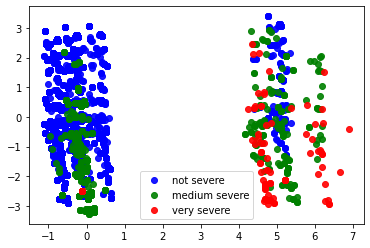

In [ ]:
#gráfico de primeros 2 componentes(PCA), color indica severidad
Xax = Xt[:,0]
Yax = Xt[:,1]
group=sev
cdict = {0: 'blue', 1: 'green', 2: 'red'}
labl = {0:'not severe',1:'medium severe',2:"very severe"}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(Xax[ix], Yax[ix], c = cdict[g], label=labl[g], alpha= 0.9, cmap="viridis")
ax.legend()
plt.savefig("/content/drive/MyDrive/Graficos/cardio/fig1.pdf")

plt.show()




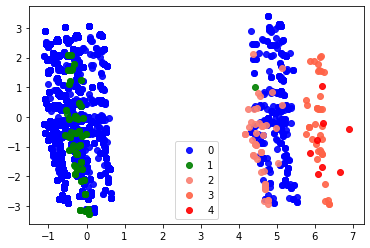

In [ ]:
#gráfico de primeros 2 componentes(PCA), color indica cluster dbscan
Xax = Xt[:,0]
Yax = Xt[:,1]
group=df["db_sev"]
cdict = {0: 'blue', 1: 'green', 2: 'salmon',3:"tomato",4:"red"}
labl = {0:0,1:1,2:2,3:3,4:4}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(Xax[ix], Yax[ix], c = cdict[g],label=labl[g], alpha= 0.9, cmap="viridis")
ax.legend()
#plt.savefig("/content/drive/MyDrive/Graficos/cardio/fig2.pdf")

plt.show()

In [ ]:
#gráfico 3d dinámico de primeros 3 componentes(PCA). Color indica cluster identificados con DBSCAN.

fig = px.scatter_3d(Xt, x=Xt[:,0], y=Xt[:,1], z=Xt[:,2],
                    color=pred.labels_,title="Primeros 3 componentes ")
fig.update_traces(marker=dict(size=6,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [ ]:
#gráfico 3d dinámico de primeros 3 componentes(PCA). Color indica severidad.

fig = px.scatter_3d(Xt, x=Xt[:,0], y=Xt[:,1], z=Xt[:,2],
                    color=sev,title="Primeros 3 componentes ")
fig.update_traces(marker=dict(size=6,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
target=pred.labels_
#target=df["db_sev"]

In [ ]:
# divide dataset en train y test para entrenar arbol de clasificación
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(df_2, target, test_size = 0.4, random_state = 42)

In [ ]:
#pd.DataFrame(X_train_db).to_csv('/content/drive/MyDrive/Dataset/X_train_db.csv')
#pd.DataFrame(X_test_db).to_csv('/content/drive/MyDrive/Dataset/X_test_db.csv')
#pd.DataFrame(y_train_db).to_csv('/content/drive/MyDrive/Dataset/y_train_db.csv')
#pd.DataFrame(y_test_db).to_csv('/content/drive/MyDrive/Dataset/y_test_db.csv')